# DATASET FOR 330 ER GRAPHS

In [1]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.visualization import plot_histogram, circuit_drawer, plot_state_qsphere
from qiskit_aer import AerSimulator
from qiskit_aer.noise import pauli_error, NoiseModel, depolarizing_error
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.quantum_info import Statevector, Kraus, SuperOp
from qiskit_ibm_runtime import SamplerV2
from qiskit.result import sampled_expectation_value
from qiskit.quantum_info import Pauli

In [2]:
import networkx as nx

In [3]:
from qiskit.circuit import ParameterVector

In [4]:
import matplotlib.pyplot as plt

In [5]:
from qiskit.quantum_info import SparsePauliOp

In [6]:
from qiskit_ibm_runtime import EstimatorV2
estimator = EstimatorV2(backend=AerSimulator())

In [7]:
from scipy.optimize import minimize

In [8]:
import csv

In [9]:
import pandas as pd

In [10]:
def create_qaoa_circuit(p, n, G):
    
    gamma = ParameterVector('γ',p)
    beta = ParameterVector('β',p)
    
    qc = QuantumCircuit(n, name='q')
    qc.h(range(n)) #superposition
    
    for i in range(p):
        for edge in G.edges(): #problem hamiltonian
            qc.rzz(gamma[i], edge[0], edge[1])
        for qubit in range(n): #mixer Hamiltonian
            qc.rx(2 * beta[i], qubit)
        if i != p-1:
            qc.barrier()
    return qc

In [11]:
def create_observables(graph, nodes):
    observables = []
    for edge in graph.edges():
        str = 'I'*nodes
        s_list = list(str)
        s_list[edge[0]]='Z'
        s_list[edge[1]]='Z'
        new_string = ''.join(s_list)
        observables.append(SparsePauliOp(new_string))
    return observables

In [12]:
def obtain_expval(params: list, qaoa: QuantumCircuit, observables: list, estimator) -> float:
    # execute the circuit
    job = estimator.run([(qaoa, observables, params)])
    result = job.result()[0]

    # sum up values
    value = sum(result.data.evs)

    return value

# DATA GENERATING LOOP

In [ ]:
num_graphs = 330
for _ in range(num_graphs):
    graph = nx.erdos_renyi_graph(8, 0.5)
    for depth in range(6):
        params_arr = [0,0,0,0,0,0,0,0,0,0,0,0]
        qaoa = create_qaoa_circuit(depth+1, 8, graph)
        qaoa.measure_all()
        observables = create_observables(graph, nodes=8)
        init_params = [0]*qaoa.num_parameters
        qaoa_params = qaoa.assign_parameters(init_params)
        ideal_res = minimize(
            obtain_expval, init_params, args=(qaoa.copy(), observables, estimator), method="L-BFGS-B"
        )
        params_arr[ : depth+1]=ideal_res.x[ : depth+1]
        params_arr[6 : depth+7] = ideal_res.x[depth+1 : ]
        params_arr.append(depth+1)
        params_arr = np.array(params_arr)
        with open('data(L-BFGS-B).csv', mode='a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(params_arr)

# TRAINING THE MODEL ON DATASET

In [13]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import LinearRegression
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

In [14]:
file_path = 'data(L-BFGS-B).csv'
data = pd.read_csv(file_path)

In [15]:
#Extract features and target variable y
X_columns = [data.columns[0], data.columns[6], data.columns[12]]
X = data[X_columns]
y_columns = [col for col in data.columns if col not in X_columns]
y = data[y_columns]

In [16]:
X.head()

,gamma1,beta1,depth
0,2.639868e-07,2.236358e-06,1.0
1,-2.755805e-07,-2.060677e-07,2.0
2,0.000000e+00,0.000000e+00,3.0
3,-1.753022e-07,-1.489952e-07,4.0
4,-6.663543e-07,-4.564501e-07,5.0


In [17]:
y.head()

,gamma2,gamma3,gamma4,gamma5,gamma6,beta2,beta3,beta4,beta5,beta6
0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.0
1,-7.814208e-08,0.000000e+00,0.000000e+00,0.000000e+00,0.0,-9.902998e-08,0.000000e+00,0.000000e+00,0.000000,0.0
2,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.0
3,1.216465e-07,-3.678863e-08,-3.101869e-08,0.000000e+00,0.0,3.353710e-07,-5.846321e-08,2.003181e-07,0.000000,0.0
4,-3.058373e-07,-2.726339e-07,-2.549919e-07,-6.540048e-07,0.0,-2.327491e-07,2.946586e-07,-2.411677e-07,-0.000001,0.0


In [18]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
from sklearn.preprocessing import StandardScaler

In [20]:
# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [21]:
# Define the Gaussian Process Regressor
kernel = C(1.0, (1e-5, 1e5)) * RBF(1.0, (1e-5, 1e5))
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-10)

---

In [ ]:
# Define the hyperparameters grid
param_grid = {
    'alpha': [1e-10, 1e-5, 1e-2, 1e-1, 1.0],                                                               #Adjusts the noise level in the Gaussian Process.
    'n_restarts_optimizer': [0, 5, 10],                                                                    #Controls the number of optimizer restarts to avoid local minima.
    'kernel': [C(1.0, (1e-2, 1e2)) * RBF(length_scale, (1e-2, 1e2)) for length_scale in [0.1, 1.0, 10.0]]  #Defines different combinations of ConstantKernel & RBF kernels with varying length scales.
}

In [ ]:
# Use GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(estimator=gpr, param_grid=param_grid, cv=3, n_jobs=-1, scoring='r2')
grid_search.fit(X_train, y_train)

In [ ]:
# Get the best model
best_gpr = grid_search.best_estimator_

---

In [22]:
y_train.shape

(1584, 10)

In [23]:
# Train the model for each target column
gpr_models = []
for i in range(y_train.shape[1]):
    gpr.fit(X_train, y_train.iloc[:, i])
    gpr_models.append(gpr)
# Predict the test set using the trained models
y_pred = np.zeros(y_test.shape)
for i, model in enumerate(gpr_models):
    y_pred[:, i] = model.predict(X_test)

/home/poulami/anaconda3/envs/quantum/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/poulami/anaconda3/envs/quantum/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/poulami/anaconda3/envs/quantum/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/poulam

In [24]:
# Make predictions on the testing set
#y_pred, sigma = best_gpr.predict(X_test, return_std=True)
#y_pred, sigma = gpr.predict(X_test, return_std=True)

In [25]:
y_test.shape

(396, 10)

In [26]:
type(y_pred)

numpy.ndarray

In [27]:
for i in range(y_test.shape[1]):
    mse = mean_squared_error(y_test.iloc[:, i], y_pred[:, i])
    r2 = r2_score(y_test.iloc[:, i], y_pred[:, i])
    print(f"Parameter {i+1}: MSE = {mse}, R² = {r2}")

Parameter 1: MSE = 9.545280100005387e-13, R² = -0.01476978586044031
Parameter 2: MSE = 4.882541478860358e-13, R² = -0.02676440215945486
Parameter 3: MSE = 1.6695455699587487e-13, R² = -0.002855256386860461
Parameter 4: MSE = 8.672117900308126e-14, R² = -0.00011234130278503507
Parameter 5: MSE = 4.979684685557022e-14, R² = 0.00017439871291813347
Parameter 6: MSE = 1.0617506754553514e-12, R² = -0.025085738694169857
Parameter 7: MSE = 3.416943603183793e-13, R² = -0.018102425341911976
Parameter 8: MSE = 5.022285628227284e-13, R² = -0.0072868847903071465
Parameter 9: MSE = 1.0614942132899081e-13, R² = -0.0036812022651953047
Parameter 10: MSE = 3.6546218825793093e-14, R² = -0.014602739813362131


In [28]:
y_pred_df = pd.DataFrame(y_pred, columns=[f'{i+1}' for i in range(y_pred.shape[1])])

In [29]:
y_pred_df.head

<bound method NDFrame.head of                 1             2             3             4             5  \
0    1.170995e-08  1.170995e-08  1.170995e-08  1.170995e-08  1.170995e-08   
1    1.252599e-08  1.252599e-08  1.252599e-08  1.252599e-08  1.252599e-08   
2    1.269706e-08  1.269706e-08  1.269706e-08  1.269706e-08  1.269706e-08   
3    1.236347e-08  1.236347e-08  1.236347e-08  1.236347e-08  1.236347e-08   
4    1.260493e-08  1.260493e-08  1.260493e-08  1.260493e-08  1.260493e-08   
..            ...           ...           ...           ...           ...   
391  1.236347e-08  1.236347e-08  1.236347e-08  1.236347e-08  1.236347e-08   
392  1.303065e-08  1.303065e-08  1.303065e-08  1.303065e-08  1.303065e-08   
393  1.303065e-08  1.303065e-08  1.303065e-08  1.303065e-08  1.303065e-08   
394  1.276026e-08  1.276026e-08  1.276026e-08  1.276026e-08  1.276026e-08   
395  1.236704e-08  1.236704e-08  1.236704e-08  1.236704e-08  1.236704e-08   

                6             7             8

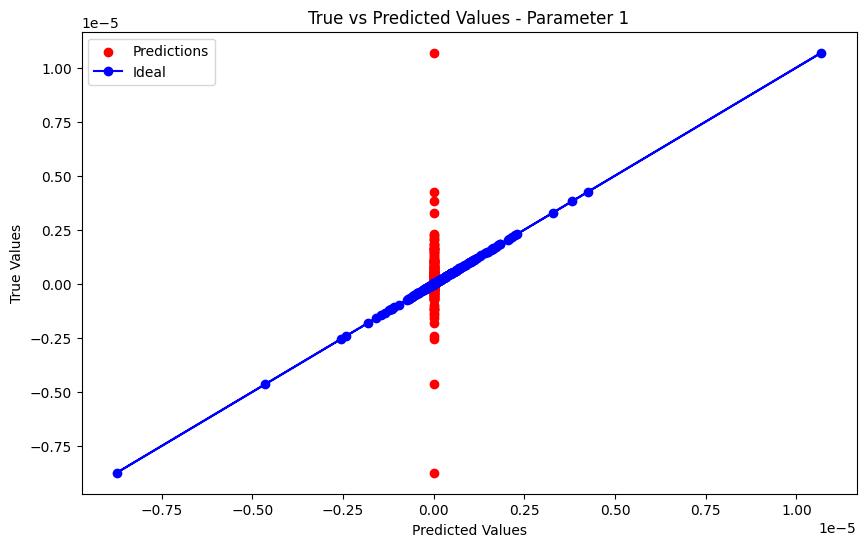

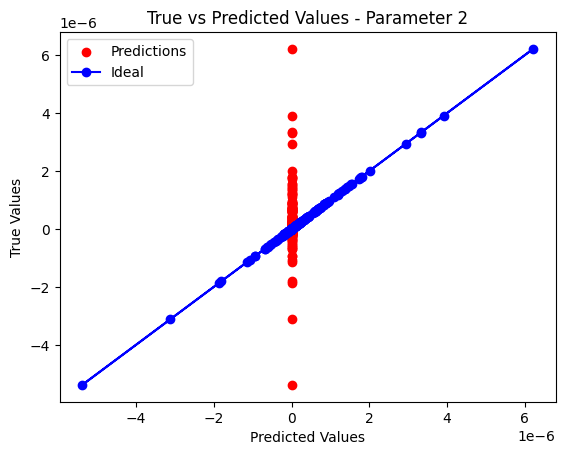

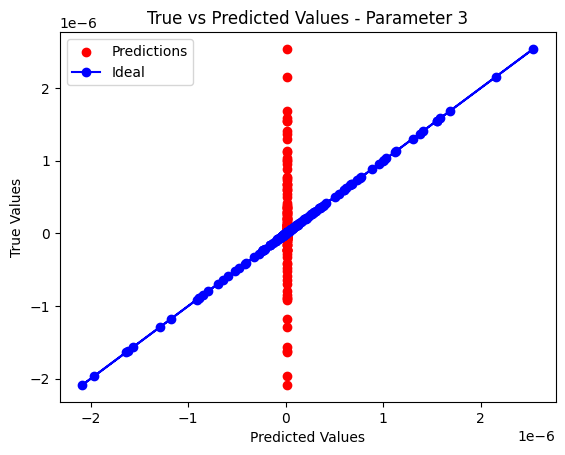

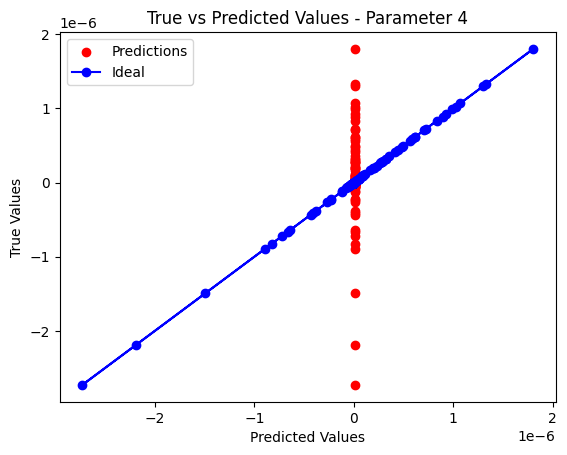

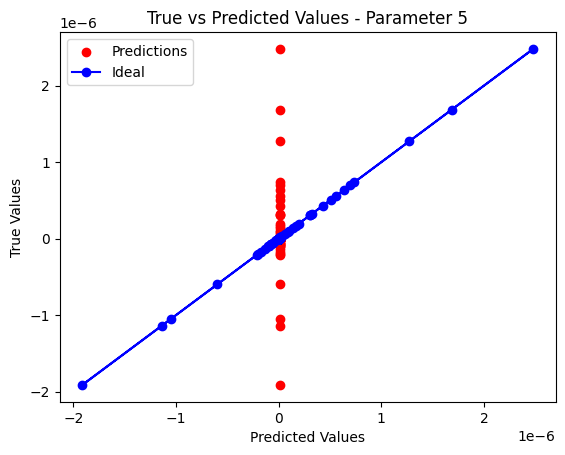

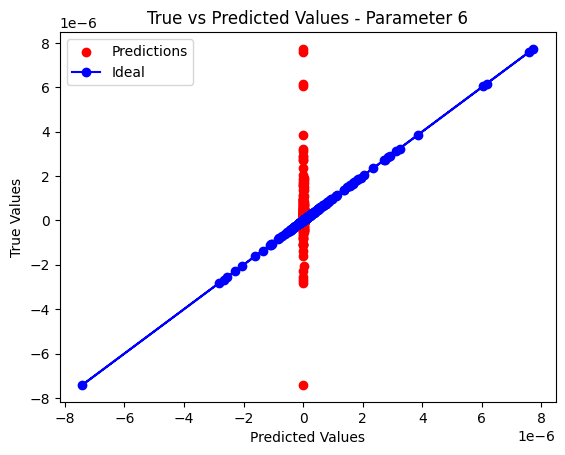

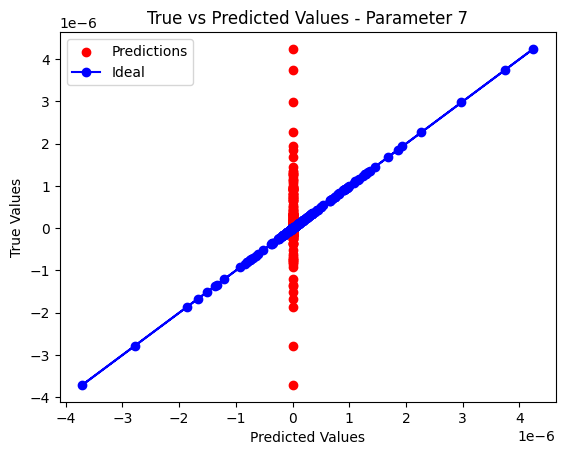

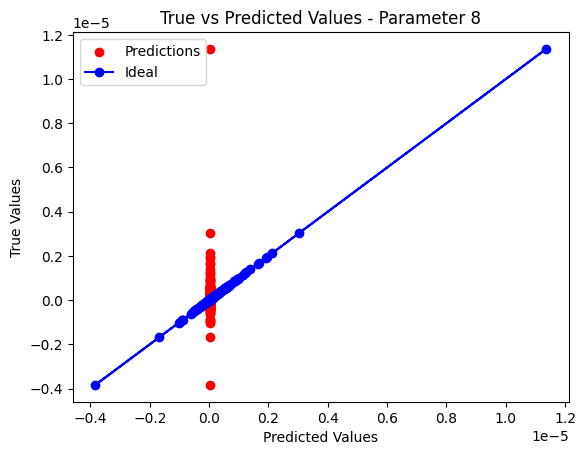

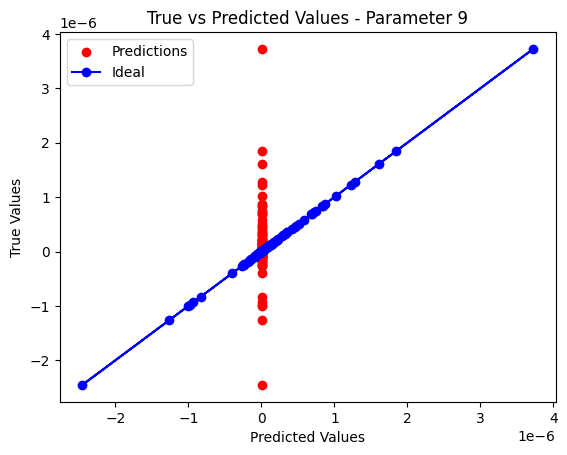

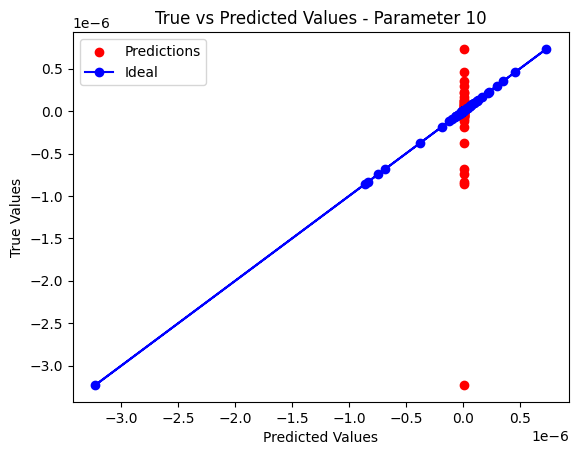

In [63]:
# Plot the predictions vs true values
plt.figure(figsize=(10, 6))
for i in range (10):
    #plt.subplot(5, 2, i + 1)
    plt.scatter(y_pred_df.iloc[:, i], y_test.iloc[:, i], c='r', marker='o', label='Predictions')
    plt.plot(y_test.iloc[:, i], y_test.iloc[:, i], c='b', marker='o', label='Ideal')
    #plt.plot([y_test.iloc[:, i].min(), y_test.iloc[:, i].max()],
     #        [y_test.iloc[:, i].min(), y_test.iloc[:, i].max()], 'k--', lw=3, label='Ideal')
    plt.ylabel('True Values')
    plt.xlabel('Predicted Values')
    plt.title(f'True vs Predicted Values - Parameter {i + 1}')
    plt.legend()
    plt.show()
#plt.tight_layout()
#plt.show()

# COMPARING NAIVE AND TWO FOLD APPROACH

In [31]:
import joblib
# Save the model
joblib.dump(gpr_models, 'gpr_models.pkl')
# Save the scaler
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [32]:
gpr_models = joblib.load('gpr_models.pkl')
scaler = joblib.load('scaler.pkl')

### NAIVE APPROACH

In [33]:
import time

In [34]:
nodes = 8
t_depth = 5
graph = nx.erdos_renyi_graph(nodes, 0.5)
qaoa = create_qaoa_circuit(t_depth, nodes, graph)
qaoa.measure_all()
observables = create_observables(graph, nodes)
init_params = [0]*qaoa.num_parameters
qaoa_params = qaoa.assign_parameters(init_params)
start = time.time()
ideal_res = minimize(
        obtain_expval, init_params, args=(qaoa.copy(), observables, estimator), method="L-BFGS-B"
)
end = time.time()
elapsed_time = end - start
print(f"Elapsed time: {elapsed_time} seconds")

Elapsed time: 8.258199214935303 seconds


In [35]:
ideal_res

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -0.01171875
        x: [ 2.329e-08 -8.885e-08  5.911e-08  5.077e-08 -6.716e-07
            -2.196e-07  1.426e-07 -3.330e-07 -1.768e-07 -2.599e-08]
      nit: 3
      jac: [ 1.099e+07  1.445e+07  6.055e+06 -4.980e+06 -1.904e+06
            -6.055e+06  8.008e+06 -5.029e+06  1.050e+07  1.465e+06]
     nfev: 352
     njev: 32
 hess_inv: <10x10 LbfgsInvHessProduct with dtype=float64>

### TWO FOLD APPROACH

In [36]:
depth=1
qaoa = create_qaoa_circuit(depth, nodes, graph)
qaoa.measure_all()
observables = create_observables(graph, nodes)
init_params = [0]*qaoa.num_parameters
qaoa_params = qaoa.assign_parameters(init_params)
ideal_res_new = minimize(
        obtain_expval, init_params, args=(qaoa.copy(), observables, estimator), method="L-BFGS-B"
)

In [37]:
ideal_res_new

  message: ABNORMAL_TERMINATION_IN_LNSRCH
  success: False
   status: 2
      fun: -0.04248046875
        x: [ 0.000e+00  0.000e+00]
      nit: 0
      jac: [-4.785e+06  1.079e+07]
     nfev: 63
     njev: 21
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>

In [38]:
arr = []
arr = arr + list(ideal_res_new.x)
arr.append(t_depth)

In [39]:
arr=np.array(arr)

In [40]:
arr

array([0., 0., 5.])

In [41]:
arr.shape

(3,)

In [42]:
X.shape

(1980, 3)

In [43]:
arr=arr.reshape(1,-1)

In [44]:
arr.shape

(1, 3)

In [45]:
#new_data = scaler.transform(arr)
data = arr[0]
predictions = []
for i in range(int(data[2]-1)):
    predictions.append(gpr_models[i].predict(arr))

for i in range(int(data[2]-1)):
    predictions.append(gpr_models[i+5].predict(arr))

In [46]:
predictions

[array([1.4052033e-08]),
 array([1.4052033e-08]),
 array([1.4052033e-08]),
 array([1.4052033e-08]),
 array([1.4052033e-08]),
 array([1.4052033e-08]),
 array([1.4052033e-08]),
 array([1.4052033e-08])]

In [47]:
type(predictions)

list

In [48]:
init_params = predictions
init_params.insert(0, data[0])
init_params.insert(t_depth, data[1])

In [49]:
list(init_params)

[0.0,
 array([1.4052033e-08]),
 array([1.4052033e-08]),
 array([1.4052033e-08]),
 array([1.4052033e-08]),
 0.0,
 array([1.4052033e-08]),
 array([1.4052033e-08]),
 array([1.4052033e-08]),
 array([1.4052033e-08])]

In [50]:
init_params = [item if not isinstance(item, np.ndarray) else item.item() for item in init_params]

In [51]:
init_params

[0.0,
 1.4052032953904003e-08,
 1.4052032953904003e-08,
 1.4052032953904003e-08,
 1.4052032953904003e-08,
 0.0,
 1.4052032953904003e-08,
 1.4052032953904003e-08,
 1.4052032953904003e-08,
 1.4052032953904003e-08]

In [52]:
qaoa = create_qaoa_circuit(t_depth, nodes, graph)
qaoa.measure_all()
observables = create_observables(graph, nodes)
qaoa_params = qaoa.assign_parameters(init_params)
start = time.time()
ideal_res_new2 = minimize(
        obtain_expval, init_params, args=(qaoa.copy(), observables, estimator), method="L-BFGS-B"
)
end = time.time()
elapsed_time_new = end - start
print(f"Elapsed time: {elapsed_time_new} seconds")

Elapsed time: 6.857861280441284 seconds


In [53]:
ideal_res_new2

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -0.01806640625
        x: [-2.505e-07 -2.037e-07  9.349e-10  4.291e-08 -1.001e-07
            -7.477e-08 -3.231e-07 -1.827e-07  2.455e-08 -3.808e-07]
      nit: 2
      jac: [-3.906e+05 -1.611e+06  4.590e+06  3.662e+06 -5.908e+06
             8.301e+06  1.709e+06  4.639e+06 -4.199e+06  1.025e+06]
     nfev: 297
     njev: 27
 hess_inv: <10x10 LbfgsInvHessProduct with dtype=float64>

In [58]:
print("number of iterations in naive approach : ", ideal_res.nit)
print("number of iterations in two-fold approach : ", ideal_res_new2.nit)
print("number of seconds in naive approach : ", elapsed_time)
print("number of seconds in two-fold approach : ", elapsed_time_new)

number of iterations in naive approach :  3
number of iterations in two-fold approach :  2
number of seconds in naive approach :  8.258199214935303
number of seconds in two-fold approach :  6.857861280441284


In [59]:
diff=100*(elapsed_time - elapsed_time_new)/elapsed_time
print(f'Reduction of time : {diff}%')

Reduction of time : 16.956940587742764%
